In [92]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
np.random.seed(1)

In [83]:
from scipy.stats import ttest_rel, ttest_ind

# Introduction

Table of Content
- [Error analysis and Uncertainty](#Error-analysis-and-Uncertainty)
- [RNTL vs Other layers](#Comparison-of-RNTL-vs-Other-Layers)
- [Glaucoma vs HC](#Comparison-of-Glaucoma-vs-Health-Controls)
- [Manual vs model segmentation](#Comparison-between-manual-and-model-segmentation)
- [TBD](#Repeatability)


To start with, this notebook reads in a `results.xlsx` file where:
* Each xlsx file has three sheets, one per class
* Each xlsx file has N rows, one per unique image 
* `pixels_pred`: percent of pixels labeled as that class in the model segmentation
* `pixels_true`: percent of pixels labeled as that class in the manual segmentation
* `thickness_pred`: average of vertical thickness of that class (measured as number of pixels) in the model segmentation
* `thickness_true`: paverage of vertical thickness of that class (measured as number of pixels) in the manual segmentation
* `dice`
* `auc`
* `accuracy`
* `jaccard`


In [99]:
file_name = "test_results.xlsx"
original_image_folder = ""
layer = 2

In [42]:
result1 = pd.read_excel(file_name, sheet_name="class1", index_col=0)
result2 = pd.read_excel(file_name, sheet_name="class2", index_col=0)

# Error analysis and Uncertainty

The distribution of DICE is very left-skewed -- Majority of images have high DICE and two images have very bad segmentation. We examine those images and see that...

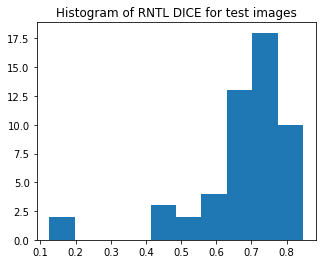

In [65]:
plt.rcParams["figure.figsize"] = (5,4)
plt.hist(result2['dice'])
plt.title("Histogram of RNTL DICE for test images")
plt.show()

In [ ]:
# TODO Visualize those worse performing images 

T-test to compare if the accuracy of certain images is singificantly higher than that of uncertain regions.

In [ ]:
ttest_rel(result2.query("uncertainty_avg>=1.0")['dice'], 
          result2.query("uncertainty_avg<1")['dice'])

Which images the model is most uncertain? What are their accuracies?


In [ ]:
plt.rcParams["figure.figsize"] = (5,4)
plt.hist(result2['uncertainty_avg'])
plt.title("Histogram of uncertainty for test images")
plt.show()

In [ ]:
# TODO: visualize images with high uncertainty

# Comparison of RNTL vs Other Layers

layer 2 have a lower accuracy than other layers; also thinner (average number of pixels is 3%).

In [45]:
result1.mean()

dice               0.849281
auc                0.926001
accuracy           0.957284
jaccard            0.759436
thickness_pred    48.890769
thickness_true    52.906297
pixels_pred        0.095490
pixels_true        0.103333
glaucoma           0.680000
dtype: float64

In [38]:
result2.mean()

dice               0.676368
auc                0.816520
accuracy           0.962169
jaccard            0.527762
thickness_pred    15.971590
thickness_true    15.404642
pixels_pred        0.031195
pixels_true        0.030087
glaucoma           0.680000
dtype: float64

Compute  "CVI; a commonly used metric that quantifies the ratio of the luminal area to the total choroidal area in a binarized OCT image"

In [53]:
result2['CVI_true'] = result2['pixels_true'] / (result1['pixels_true'] + result2['pixels_true'])
result2['CVI_pred'] = result2['pixels_pred'] / (result1['pixels_pred'] + result2['pixels_pred'])

# Comparison of with vs without data augmentation

# Comparison of Glaucoma vs Health Controls

In [86]:
result2.groupby("glaucoma").size()

glaucoma
0.0    16
1.0    34
dtype: int64

First, we test if Glaucoma subjects have more pixels than HC

In [85]:
ttest_ind(result2.query("glaucoma==0")['pixels_true'], 
          result2.query("glaucoma==1")['pixels_true'])

Ttest_indResult(statistic=1.207338293771059, pvalue=0.23321772645074867)

The glaucoma class is more difficult to classify and have a lower accuracy.
* table
* t-test
* boxplot 

In [89]:
result2.groupby("glaucoma").mean()

,dice,auc,accuracy,jaccard,thickness_pred,thickness_true,pixels_pred,pixels_true,CVI_true,CVI_pred
glaucoma,,,,,,,,,,
0.0,0.739141,0.861169,0.982723,0.591205,17.129761,16.912598,0.033457,0.033032,0.231635,0.243901
1.0,0.662728,0.816923,0.980000,0.509400,15.797335,14.988454,0.030854,0.029274,0.227317,0.258926


In [90]:
ttest_ind(result2.query("glaucoma==0")['dice'], 
          result2.query("glaucoma==1")['dice'])

Ttest_indResult(statistic=2.062255603285949, pvalue=0.04461840079307237)

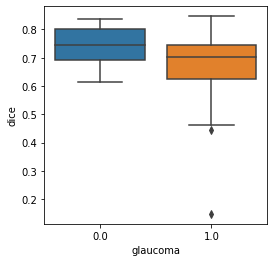

In [96]:
sns.boxplot(x="glaucoma", y="dice",  data=result2)
plt.show()

# Comparison between manual and model segmentation

## Paired-t test for equality of means of pixel counts


Paired t-test compares whether there is statistically significance between the number of pixels in a class in the manual and DL segmentations. 

In [30]:
ttest_rel(result2['pixels_true'], result2['pixels_pred'])

Ttest_relResult(statistic=-1.22746906154229, pvalue=0.22528206095021572)

Same test but only looking at health controls

In [32]:
ttest_rel(result2.query("glaucoma==0")['pixels_true'], 
          result2.query("glaucoma==0")['pixels_pred'])

Ttest_relResult(statistic=-0.2986116098055409, pvalue=0.7693333313346908)

Same test but only looking at glaucoma

In [33]:
ttest_rel(result2.query("glaucoma==1")['pixels_true'], 
          result2.query("glaucoma==1")['pixels_pred'])

Ttest_relResult(statistic=-1.3101295692374257, pvalue=0.19919869523662523)

## Correlation plots of number of pixels per class or CVI

We can show the number of pixels per class per scan in an almond graph like this, one per each class across each set. This way it would allow us to see the relationship between both human and dl segmentations.

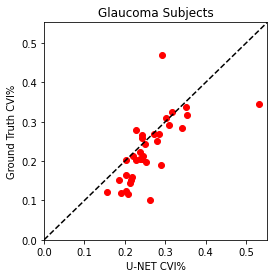

In [77]:
x1 = result2.query("glaucoma==1")['CVI_pred']
x2 = result2.query("glaucoma==1")['CVI_true']
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(x1, x2, c='r')
plt.ylabel("Ground Truth CVI%")
plt.xlabel("U-NET CVI%")
plt.axline((0, 0), linestyle='--', slope=1, color='black')
plt.xlim([0, max(max(x1),max(x2))+0.02])
plt.ylim([0, max(max(x1),max(x2))+0.02])
plt.title("Glaucoma Subjects")
plt.show()

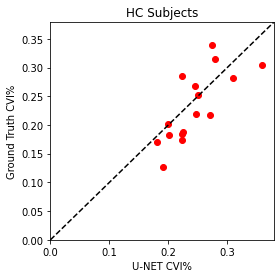

In [79]:
x1 = result2.query("glaucoma==0")['CVI_pred']
x2 = result2.query("glaucoma==0")['CVI_true']
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(x1, x2, c='r')
plt.ylabel("Ground Truth CVI%")
plt.xlabel("U-NET CVI%")
plt.axline((0, 0), linestyle='--', slope=1, color='black')
plt.xlim([0, max(max(x1),max(x2))+0.02])
plt.ylim([0, max(max(x1),max(x2))+0.02])
plt.title("HC Subjects")
plt.show()

# Repeatability

Ref: https://doi.org/10.1167/tvst.11.2.23)

Taking into consideration that all the scans included in the data set have “follow-up” scans taken at the same visit aligned at the same retinal location, a repeatability analysis was also performed comparing the two scans collected at the same visit on each participant. The repeatability was calculated as the absolute difference in the proportion of pixels for each category, given by the following formula: 

$$
R = \frac{|P_1 - P_2|}{p} \times 100 
$$

where P1 and P2 are the number of correctly classified pixels for scans 1 and 2 respectively for a given category, p is the number of total pixels in an image (224 × 896 pixels), and R provides a repeatability metric given as a percentage difference between scans 1 and 2 for each category